# MovieLens데이데이터로 별점 예측하기
## 201200737 이정현

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## csv파일 읽기

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
test = pd.read_csv('test.csv')

In [3]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


ratings.csv파일에서 10000, 20000, 30000...100000번째 데이터를 가져와 test.csv를 만들었습니다.

In [4]:
test

,userId,movieId,rating,timestamp
0,70,1356,5.0,853954485
1,133,71899,3.0,1416147749
2,213,73015,2.0,1462636831
3,292,4014,4.5,1140148958
4,367,555,3.5,1128631203
5,433,8528,3.5,1417930329
6,483,1527,3.0,1465387443
7,547,8492,4.5,1199576393
8,597,2662,3.0,940707473
9,71,6212,2.5,1065149436


## 1. Data Processing
### User X Movie Matrix 만들기
index는 유저아이디, column은 무비아이디로 하는 매트릭스를 만듭니다.<br>
매트릭스의 값은 유저가 해당 영화에 매긴 별점으로 채웁니다.

In [5]:
UM_matrix_ds = ratings.pivot(index='userId', columns='movieId', values='rating')

print("UM Matrix value size", UM_matrix_ds.values.size)
print("ratings value size", ratings.values.size)

UM Matrix value size 6083286
ratings value size 400016


In [6]:
UM_matrix_ds.head(2)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Neighborhood
### test.csv에 존재하는 사용자들의 가장가까운 이웃 3명씩 찾기
유사도를 측정하기 위해 cosine, correlation, euclidean함수를 사용합니다.

In [7]:
import math
from operator import itemgetter
from scipy.spatial import distance

def distance_cosine(a, b):
    return 1-distance.cosine(a,b)

def distance_correlation(a, b):
    return 1-distance.correlation(a,b)

def distance_euclidean(a, b):
    return 1/(distance.euclidean(a,b)+1)

사용자와 유사한 neighbor를 찾는 함수입니다.<br>
위의 User X Movie Matrix에서 사용자와 최소 3번의 같은 영화에 대해 별점을 매긴 사용자를 neighbor로 하여 유사도함수를 통해 유사도를 측정하고, 정렬을 하여 topN neighbor를 찾습니다.

In [8]:
def nearest_neighbor_user(user, topN, simFunc):
    u1 = UM_matrix_ds.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    ## Brote Force Compute
    for uid, row in UM_matrix_ds.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        
        if uid == user:
            continue
            
        for i in ratedIndex:
            if False == math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
        ## At least 3 intersection items
        if interSectionLen < 3:
            continue
            
        ## similarity function
        sim = simFunc(interSectionU1, interSectionU2)
        
        if math.isnan(sim) == False:
            nn[uid] = sim
            
    ## top N returned
    return sorted(nn.items(), key=itemgetter(1))[:-(topN+1):-1]

유사도 함수로 distance_euclidean을 사용하여 test.csv에 있는 유저들의 top 3 neighbor를 찾습니다.

In [9]:
for user in test['userId']:
    print(nearest_neighbor_user(user, 3, distance_euclidean))

[(354, 1.0), (115, 0.6666666666666666), (544, 0.585786437626905)]
[(539, 0.38742588672279304), (50, 0.3761785115301142), (444, 0.3567891723253309)]
[(634, 0.6666666666666666), (35, 0.38742588672279304), (1, 0.38742588672279304)]
[(76, 1.0), (515, 0.585786437626905), (485, 0.585786437626905)]
[(618, 1.0), (391, 0.6666666666666666), (211, 0.6666666666666666)]
[(668, 0.585786437626905), (154, 0.585786437626905), (331, 0.5358983848622454)]
[(631, 1.0), (252, 0.6666666666666666), (194, 0.6666666666666666)]
[(397, 0.4142135623730951), (113, 0.32037724101704074), (129, 0.2989350844248255)]
[(223, 1.0), (524, 0.585786437626905), (208, 0.5358983848622454)]
[(569, 1.0), (139, 1.0), (125, 0.6666666666666666)]


## 3. Prediction
### test.csv에 존재하는 사용자와 영화의 별점 예측하기
유사도함수를 이용해 topN neighbor를 구하고, neighbor중에서 최소 2개의 영화에 별점을 매긴 neighbor의 별점을 이용해 사용자가 별점을 예측합니다.<br>
data set이 작아서 threshold를 높이면 별점을 예측하지 못하여 threshold를 2로 정했습니다.

In [10]:
def predictRating(userId, nn=50, simFunc=distance_euclidean):
    
    ## neighborhood
    neighbor = nearest_neighbor_user(userId, nn, simFunc)
    neighbor_id = [id for id, sim in neighbor]
    
    ## neighborhood's movie : at least 2 ratings
    neighbor_movie = UM_matrix_ds.loc[neighbor_id]\
                    .dropna(1, how='all', thresh=2)
    neighbor_dic = (dict(neighbor))
    ret = [] # ['movieID', 'predictedRate']
    
    ## rating predict by my similarities
    for movieId, row in neighbor_movie.iteritems():
        jsum, wsum = 0, 0
        for v in row.dropna().iteritems():
            sim = neighbor_dic.get(v[0], 0)
            jsum += sim
            wsum += (v[1]*sim)
        ret.append([movieId, wsum/jsum])
        
    return ret

유사도함수로 euclidean을 사용하고 670명의 neighbor의 정보를 이용하여 test.csv파일에 있는 유저들의 별점을 예측합니다.<br>
test.csv파일에 있는 영화에 대해 예측한 별점을 rating_pred에 저장합니다.<br>
data set이 작아서 ratings.csv파일에 있는 모든 유저의 정보를 이용하여 별점을 예측하기 위해 neighbor를 670명으로 했습니다.

In [11]:
rating_pred = []
for user in test['userId']:
    ans = predictRating(user, 670)
    for a in ans:
        if a[0] == int(test.loc[test['userId'] == user]['movieId']):
            rating_pred.append(a)
rating_pred

[[1356, 3.922699669840723],
 [71899, 4.0232232589460883],
 [73015, 2.6157764047649095],
 [4014, 3.8733547274404936],
 [555, 3.8939150951889747],
 [8528, 3.4441394985068077],
 [1527, 3.7088591186367594],
 [8492, 3.7010606733495583],
 [2662, 3.4987048340420013],
 [6212, 2.63802171197477]]

## 4. Accuracy
### 예측 정확도 구하기
test.csv파일에 있는 실제 별점을 rating_true에 저장합니다.

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rating_true = []

for i in range(0, 10):
    rating_true.append([int(test.iloc[i]['movieId']), test.iloc[i]['rating']])

rating_true

[[1356, 5.0],
 [71899, 3.0],
 [73015, 2.0],
 [4014, 4.5],
 [555, 3.5],
 [8528, 3.5],
 [1527, 3.0],
 [8492, 4.5],
 [2662, 3.0],
 [6212, 2.5]]

위에서 예측한 별점과 실제 별점을 비교하여 에러율을 구합니다.
- Mean Square Error

In [13]:
mean_squared_error(rating_true, rating_pred, multioutput='raw_values')

array([ 0.       ,  0.4546258])

- Mean Absolute Error

In [14]:
mean_absolute_error(rating_true, rating_pred, multioutput='raw_values')

array([ 0.        ,  0.59372459])

- 그래프로 에러 비교하기

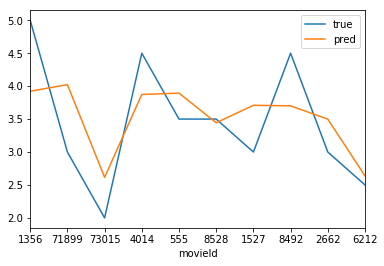

In [15]:
df_rating = pd.DataFrame(columns = ['true', 'pred'])

for i in range(0, 10):
    df_rating.loc[i] = [rating_true[i][1], rating_pred[i][1]]
df_rating.index = test['movieId'].astype(str)

df_rating.plot()
plt.show()